![](terminator.png)

# Haar OpenCV Face Detect

Kevin J. Walchko, Phd

7 Dec 2016

-----------

Why is a robotics class learning about face detection? Well, there are numerous applications where robots (or cyborgs) interact with humans and it might be useful for them to recognize a human. In this lesson we will learn how to detect faces in an image using OpenCV. We we will also understand, at a high level, how the process works. 

![](real-time-face-tracking.gif)

## Recognition vs Detection

Note that we are not detecting if "Bob" is in the image, we are detecting if a human face is in the image ... that is an important distinction. The Director of National Intelligence (DNI) recently held a [contest](https://arstechnica.com/tech-policy/2017/06/got-a-face-recognition-algorithm-uncle-sam-wants-to-review-it/) to:

    The goal of the Face Recognition Prize Challenge is to improve core face recognition accuracy and expand the breadth of capture conditions and environments suitable for successful face recognition. The Challenge comes in two parts: 1) Face identification involves executing one-to-many search to return the correct entry from a gallery, if any; 2) Face verification requires the algorithm to match two faces of the same person while correctly rejecting faces of different persons. Both tasks involve “non-cooperative” images where subjects were unaware of the camera or, at least, did not engage with, or pose for, the camera.

This is a challenging application with currently no robust solution for real-world military/intel/law enforcement applications. TV/movies would have you believe this is simple, but it is not. Take a look at these memes:

![](chihuahua-or-muffin.jpg)

![](poodle-or-fried-chicken.jpg)

For some of the pictures above, even a human needs to take a second look to understand what they are looking at.

## Objectives

- use OpenCV to detect human faces in an image
- understand how LBP and Haar are used to detect faces
- understand how to extend this to other things like cats! ([everyone loves cats](http://www.slate.com/blogs/future_tense/2012/06/27/google_computers_learn_to_identify_cats_on_youtube_in_artificial_intelligence_study.html))

## References

- [OpenCV 3.x Haar Tutorial](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html)
- [Wikipedia Viola-Jones detector](https://en.wikipedia.org/wiki/Viola%E2%80%93Jones_object_detection_framework)
- [Wikipedia Adaboost description](https://en.wikipedia.org/wiki/AdaBoost)
- [Wikipedia XML definition](https://en.|wikipedia.org/wiki/XML)
- [Good explaination of OpenCV's face detection process](https://www.superdatascience.com/opencv-face-detection/)
- [OpenCV and face recognition](https://www.superdatascience.com/opencv-face-recognition/)
- [OpenCV face detection](https://github.com/informramiz/Face-Detection-OpenCV)
- [Principle Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)

## Setup

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import cv2
from math import sqrt

In [3]:
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

# Face Detector

We need a way for a computer to find a human face in an image ... easy for you and me, but not always for a computer. Here, a friendly terminator is sizing up a human it found.

![](terminator-vision.png)

# OpenCV Face Detection

All human faces share some similar properties. A few properties common to human faces:

- The eye region is darker than the upper-cheeks.
- The nose bridge region is brighter than the eyes.

A Classifier determines if an image (or region of an image) contains a face or not. Classifiers are trained on hundreds of thousands of face and non-face images to learn how to classify a new image correctly. OpenCV comes with 2 pre-trained face detection classifiers:

- Haar Classifier
- Local Binary Patterns Classifier

Both of these classifiers process gray scale images and classify them as face or no face. The data files for this are located in the [OpenCV source, `data` folder](https://github.com/opencv/opencv/tree/master/data) as an XML file. Each file starts with the name of the classifier it belongs to (i.e., a Haar cascade classifier starts off as `haarcascade_frontalface_alt.xml`).

## Haar Classifier

Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, "Rapid Object Detection using a Boosted Cascade of Simple Features" in 2001. It is a machine learning based approach where a cascade function is trained from a lot of positive (faces in the image) and negative images (no faces in the image). It is then used to detect objects (faces in this case) in other images. The algorithm has four stages:

1. Haar Feature Selection
1. Creating an Integral Image
1. Adaboost Training
1. Cascading Classifiers

Let's look at this in a little more detail:

1. It starts by extracting Haar features from each image as shown by the windows below:

  ![](haarfeatures.png)

  Each window is placed on the picture to calculate a single feature. This feature is a single value obtained by subtracting the sum of pixels under the white part of the window from the sum of the pixels under the black part of the window: $feature = \sum{pixel_{white}} - \sum{pixel_{black}}$. 
  
2. Now, all possible sizes of each window are placed on all possible locations of each image to calculate plenty of features.

  ![](haar.png)

  For example, in the above image, we are extracting two features. The first one focuses on the property that the region of the eyes is often darker than the area of the nose and cheeks. The second feature relies on the property that the eyes are darker than the bridge of the nose.
  
  Now the integral image, is the sum of the results from the Haar features in step 1 added together for each pixel location. Below is the best example I could find, but it is actually a product of another method called fisherfaces.
  
  ![](fisherfaces.png)

3. But among all these features calculated, most of them are irrelevant. For example, when used on the cheek, the windows become irrelevant because none of these areas are darker or lighter than other regions on the cheeks, all sectors here are the same.

  So we promptly discard irrelevant features and keep only those relevant with a fancy technique called Adaboost. **AdaBoost** is a training process for face detection, which selects only those features known to improve the classification (face/non-face) accuracy of our classifier.

4. In the end, the algorithm considers the fact that generally: most of the region in an image is a non-face region. Considering this, it’s a better idea to have a simple method to check if a window is a non-face region, and if it's not, discard it right away and don’t process it again. So we can focus mostly on the area where a face is. Thus, a **cascade** of gradually more complex classifiers achieves even better detection rates and quickly eliminates images without faces.


## Local Binary Patterns (LBP) Cascade Classifier

The LBP classifier also needs to be trained on hundreds of images. LBP is a visual/texture descriptor, and thankfully, our faces are also composed of micro visual patterns. So how do we compute these feature vectors?

![](lbp-labeling.png)

So, LBP features are extracted to form a feature vector that classifies a face from a non-face. Each training image is divided into some blocks and for each block, LBP looks at 9 pixels (3x3 window) at a time. Then, it compares the central pixel value with every neighbor's pixel value under the 3x3 window. For each neighbor pixel that is greater than or equal to the center pixel, it sets its value to 1, and for the others, it sets them to 0.

After that, it reads the updated pixel values (which can be either 0 or 1) in a clockwise order and forms a binary number. Next, it converts the binary number into a decimal number, and that decimal number is the new value of the center pixel. We do this for every pixel in a block. Then, it converts each block values into a histogram, so now we have gotten one histogram for each block in an image, like this:

![](lbp-histogram.png)

Finally, it concatenates these block histograms to form a one feature vector for one image, which contains all the features we are interested. So, this is how we extract LBP features from a picture.

## Haar vs LBP

### Haar
- Pros
  - High detection accuracy
  - Low false positive rate
- Cons
  - Computationally complex and slow
  - Longer training time
  - Less accurate on black faces
  - Limitations in difficult lighting conditions
  - Less robust to occlusions

### LBP

- Pros
  - Computationally simple and fast
  - Shorter training time
  - Robust to local illumination changes
  - Robust to occlusion
- Cons
  - Less accurate
  - High false positive rate

# Game of Thrones

Ok, let's get some good images to play with and see if we can detect things.

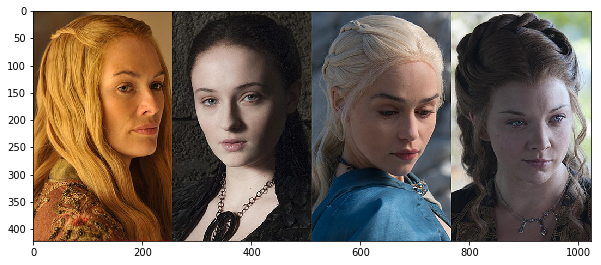

In [4]:
image = cv2.imread('face_pics/got3.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # pretty images
plt.imshow(image);

Here we will deal with detection. First we need to load the required XML classifiers. Then load our input image (or video) in grayscale mode.

In [5]:
# convert our image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# load the haar face detector for the front
faceCascade = cv2.CascadeClassifier('face_pics/haarcascade_frontalface_default.xml')

The next step is to detect faces in our image. The `cv2.CascadeClassifier.detectMultiScale` function is used to detect faces and after computation, it returns a numpy array where the co-ordinates of the faces in the image are stored. The function is called detectMultiScale because it can detect objects at multiple scales. After each level the classifier will resize the image based on the scale provided to detect the object. If the number of levels that the cascade is trained for are exhausted, then the object is not detected. The signature of the function is:

`cv2.CascadeClassifier.detectMultiScale(image, rejectLevels, levelWeights[, scaleFactor[, minNeighbors[, flags[, minSize[, maxSize[, outputRejectLevels]]]]]])`

Here,
- image – Matrix of the type CV_8U containing an image where objects are detected.
- objects – Vector of rectangles where each rectangle contains the detected object.
- scaleFactor – Parameter specifying how much the image size is reduced at each image scale.
- minNeighbors – Parameter specifying how many neighbors each candidate rectangle should have to retain it.
- flags – Parameter with the same meaning for an old cascade as in the function cvHaarDetectObjects. It is not used for a new cascade.
- minSize – Minimum possible object size. Objects smaller than that are ignored.
- maxSize – Maximum possible object size. Objects larger than that are ignored.

Faces found: 4


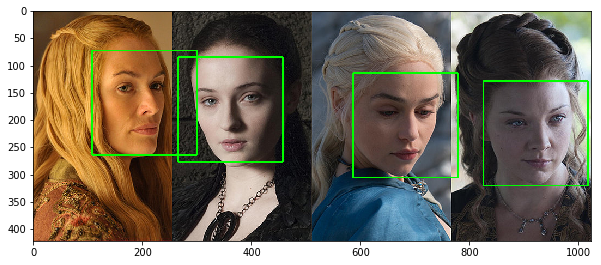

In [6]:
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=2,
    minNeighbors=2,
    minSize=(30, 30)
    #flags = cv2.CV_HAAR_SCALE_IMAGE
)

print('Faces found: {}'.format(len(faces)))

# make a copy of the image to draw on
tmp = image.copy()
for (x, y, w, h) in faces:
    cv2.rectangle(tmp, (x, y), (x+w, y+h), (0, 255, 0), 2)

plt.imshow(tmp);

# Facial Recognition

Now the next step would be to use these face and recognize them. Maybe you would want to find all Lannisters and their supporters in the image above. As I started off this lesson with the DNI challenge to highlight the point, this is really hard in real-world situations. But [here](https://www.superdatascience.com/opencv-face-recognition/) is a well written overview of how you could do it with OpenCV under ideal conditions.

# The Basics

![](wrong.png)

Again, this isn't easy.

## Steps

The coding steps for face recognition are:

- **Training Data Gathering:** Gather face data (face images in this case) of the persons you want to recognize
- **Training of Recognizer:** Feed that face data (and respective names of each face) to the face recognizer so that it can learn.
- **Recognition:** Feed new faces of the persons and see if the face recognizer you just trained recognizes them.

OpenCV comes equipped with built in face recognizer, you just have to feed it the face data.
OpenCV has three built in face recognizers and thanks to OpenCV's clean coding, you can use any of them by just changing a single line of code. Below are the names of those face recognizers and their OpenCV calls.

## Eigen Faces

1.	**EigenFaces Face Recognizer Recognizer** - cv2.face.createEigenFaceRecognizer()
    1. This algorithm considers the fact that not all parts of a face are equally important and equally useful. When you look at some one you recognize him/her by his distinct features like eyes, nose, cheeks, forehead and how they vary with respect to each other. So you are actually focusing on the areas of maximum change (mathematically speaking, this change is *variance*) of the face. For example, from eyes to nose there is a significant change and same is the case from nose to mouth. When you look at multiple faces you compare them by looking at these parts of the faces because these parts are the most useful and important components of a face. They are important because they catch the maximum change among faces, change the helps you differentiate one face from the other. This is exactly how EigenFaces face recognizer works.
    1. EigenFaces recognizer **looks at all the training images of all the persons as a whole** and try to extract the components which are important and useful (the components that catch the maximum variance/change) and discards the rest of the components. This way it not only extracts the important components from the training data but also saves memory by discarding the less important components. These important components it extracts are called **principal components** (see below). Below is an image showing the principal components extracted from a list of faces. 
    
    ![](eigenfaces.png)

### Principle Component Analysis

![](pcs.png)

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of **possibly correlated variables** into a set of values of **linearly uncorrelated variables** called principal components. The number of distinct principal components is equal to the smaller of the number of original variables or the number of observations minus one. This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components. The resulting vectors are an uncorrelated orthogonal basis set. PCA is sensitive to the relative scaling of the original variables.

## Fisher Faces

1.	**FisherFaces Face Recognizer Recognizer** - cv2.face.createFisherFaceRecognizer()
    1.	Fisherfaces algorithm is an improved version of EigenFaces face recognizer. **Eigenfaces** recognizer looks at **all the training faces of all the persons at once** and finds principal components from all of them combined. By capturing principal components from all the of them combined you are not focusing on the features that discriminate one person from the other but the features that represent all the persons in the training data as a whole.
    1.	**This approach has drawbacks**, for example, images with sharp changes (like light changes which is not a useful feature at all) may dominate the rest of the images and you may end up with features that are from external source like light and are not useful for discrimination at all. In the end, your principal components will represent light changes and not the actual face features.
    1.	Fisherfaces algorithm, instead of extracting useful features that represent all the faces of all the persons, **it extracts useful features that discriminate one person from the others**. This way features of one person do not dominate over the others and you have the features that discriminate one person from the others.
    1.	Below is an image of features extracted using Fisherfaces algorithm.
    ![](fisherfaces.png)
    1.	You can see that features extracted actually represent faces and these faces are called fisher faces and hence the name of the algorithm.
    1.	One thing to note here is that even in Fisherfaces algorithm if multiple persons have images with sharp changes due to external sources like light they will dominate over other features and affect recognition accuracy.

# Cats?

Ok, this is sort of stupid, but say you want to create a robot that will interact with your pet cat. Maybe you are gone a lot and your feline friend needs attention when you are away ... hey, this maybe a million dollar idea ... copyright me!

All kidding aside, Google (and others) has spent a lot of time and money to identify pets in pictures. Shown below, the [Google Photos App](https://www.macrumors.com/2017/10/17/google-photos-gains-pet-detection-grouping/) detects cats and dogs in your family pictures.

![](pets.jpg)

Although we have been talking about human face detection, this same idea can be used to find other things in images besides faces. OpenCV also comes with a cat detector! So let's set everything up and see it it works!

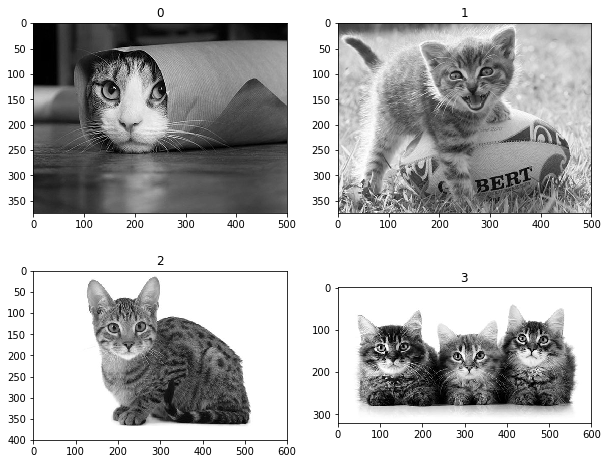

In [7]:
# read in a bunch of cat pictures
cats = []
for i in range(4):
    img = cv2.imread('cat/images/cat_0{}.jpg'.format(i + 1), 0)
    cats.append(img)
    plt.subplot(2,2,i+1)
    plt.imshow(cats[i], cmap='gray')
    plt.title(i)

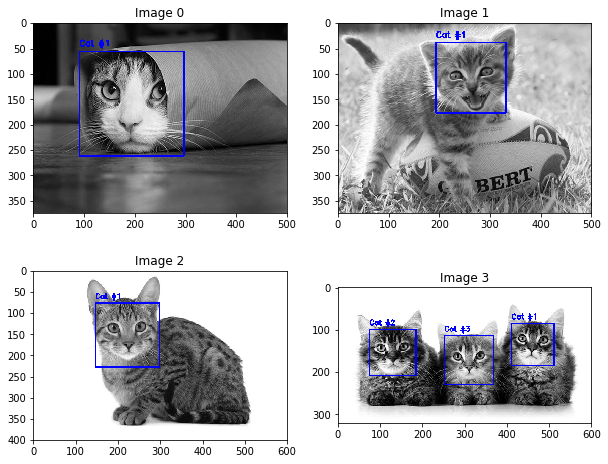

In [8]:
# this function will mark any cat faces found on the image
def markCatFace(image, rects):
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # loop over the cat faces and draw a rectangle surrounding each
    for (i, (x, y, w, h)) in enumerate(rects):
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
        cv2.putText(image, "Cat #{}".format(i + 1), (x, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 0, 255), 2)
    return image

# load the cat detector Haar cascade
detector = cv2.CascadeClassifier('cat/haarcascade_frontalcatface.xml')

# run through the array of cat pics and try to find a cat face
for i, gray in enumerate(cats):
    rects = detector.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=10, minSize=(75, 75))
    g = markCatFace(gray, rects)
    plt.subplot(2,2,i+1)
    plt.imshow(g)
    plt.title('Image {}'.format(i))

# What Else?

![](snapchat.jpg)

You could now do what snapchat does with dog filters. Infact, lab 3 will ask you to detect faces and put glasses, funny eyebrows or star wars masks on people you detect. You will be able to do this, because besides a face detector, OpenCV has an eye detector too, which will give you the location of the eyes on a face.

![](apple.gif)

You can also do a super simple version of what apple does if you know the face and eye locations. From that information alone, you could make an approximation of head orientation. However, Apple uses a 3D sensing system from Primesense (the company that originally made Microsoft's Kinect sensor), so they are able to do a lot more, but it is still the same basic idea.

# Exercise

Go ahead and write a quick python program that grabs images from the camera in your laptop and see if you can detect your face! Use code from above to draw a box around the detected face.

# Questions

1. What are the steps to the Haar face detection?
1. What is the difference between detection and recognition?
1. The Haar feature detector detects what types of features?
1. How does Haar and LBP differ in how they classify?
1. What are the pros/cons of Haar and LBP?
1. What is PCA?
1. What are the 2 recognizers we talked about?
1. Which recognizer looks at all the data at once and which looks at each image separately?


-----------

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.